<a href="https://colab.research.google.com/github/sjoon0305/KSME/blob/main/1. PINN_inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/sjoon0305/KSME/raw/main/Lorenz.npz

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습용 관측 데이터 로드
def load_data():
    data = np.load("./Lorenz.npz")
    t = torch.tensor(data["t"], dtype=torch.float32).to(device)
    y = torch.tensor(data["y"], dtype=torch.float32).to(device)
    return t, y[:, 0:1], y[:, 1:2], y[:, 2:3]

observe_t, observe_x, observe_y, observe_z = load_data()

# PINN 모델 정의
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )

    def forward(self, t):
        out = self.layers(t)
        return out[:, 0:1], out[:, 1:2], out[:, 2:3]

# 미분방정식 정의 (Lorenz System)
def inverse_lorenz(t, model, C1, C2, C3):
    x, y, z = model(t)
    dx = torch.autograd.grad(x.sum(), t, create_graph=True)[0]
    dy = torch.autograd.grad(y.sum(), t, create_graph=True)[0]
    dz = torch.autograd.grad(z.sum(), t, create_graph=True)[0]
    f1 = dx - C1 * (y - x)
    f2 = dy - x * (C2 - z) + y
    f3 = dz - x * y + C3 * z
    return f1, f2, f3

# 모델 및 학습 변수 초기화
model = PINN().to(device)
C1 = torch.tensor(1.0, requires_grad=True, device=device)
C2 = torch.tensor(1.0, requires_grad=True, device=device)
C3 = torch.tensor(1.0, requires_grad=True, device=device)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': [C1, C2, C3]}
], lr=1e-3)

mse = nn.MSELoss()

# 초기조건 (Boundary Condition)
t_bc = torch.zeros((400, 1), device=device)
x_bc = torch.full((400, 1), -8.0, device=device)
y_bc = torch.full((400, 1),  7.0, device=device)
z_bc = torch.full((400, 1), 27.0, device=device)

# 학습
loss_history = []
C1_vals, C2_vals, C3_vals = [], [], []

for epoch in range(30000):
    optimizer.zero_grad()

    # 초기조건 손실
    x_pred, y_pred, z_pred = model(t_bc)
    loss_bc = (mse(x_pred, x_bc) + mse(y_pred, y_bc) + mse(z_pred, z_bc)) / 3

    # PDE 조건 손실
    t_f = torch.rand((400, 1), device=device) * 3.0
    t_f.requires_grad = True
    f1, f2, f3 = inverse_lorenz(t_f, model, C1, C2, C3)
    loss_pde = (mse(f1, torch.zeros_like(f1)) + mse(f2, torch.zeros_like(f2)) + mse(f3, torch.zeros_like(f3))) / 3

    # 관측 데이터 손실
    x_obs, y_obs, z_obs = model(observe_t)
    loss_obs = (mse(x_obs, observe_x) + mse(y_obs, observe_y) + mse(z_obs, observe_z)) / 3

    # 전체 손실
    loss = loss_bc + loss_pde + loss_obs
    loss.backward()
    optimizer.step()

    # 로깅
    loss_history.append(loss.item())
    C1_vals.append(C1.item())
    C2_vals.append(C2.item())
    C3_vals.append(C3.item())

    if epoch % 1000 == 0:
        print(f"[{epoch:5d}] Loss: {loss.item():.4f}")



[    0] Loss: 389.3920
[ 1000] Loss: 32.8629
[ 2000] Loss: 27.4364
[ 3000] Loss: 26.6344
[ 4000] Loss: 25.9004
[ 5000] Loss: 25.2333
[ 6000] Loss: 24.4849
[ 7000] Loss: 23.6635
[ 8000] Loss: 18.1831
[ 9000] Loss: 9.3828
[10000] Loss: 5.8275
[11000] Loss: 3.8300
[12000] Loss: 2.5788
[13000] Loss: 1.9039
[14000] Loss: 1.4259
[15000] Loss: 0.8830
[16000] Loss: 0.5312
[17000] Loss: 0.3074
[18000] Loss: 0.1830
[19000] Loss: 0.1095
[20000] Loss: 0.0906
[21000] Loss: 0.0622
[22000] Loss: 0.0504
[23000] Loss: 0.0343
[24000] Loss: 0.0244
[25000] Loss: 0.0361
[26000] Loss: 0.0208
[27000] Loss: 0.0206
[28000] Loss: 0.0091
[29000] Loss: 0.0099


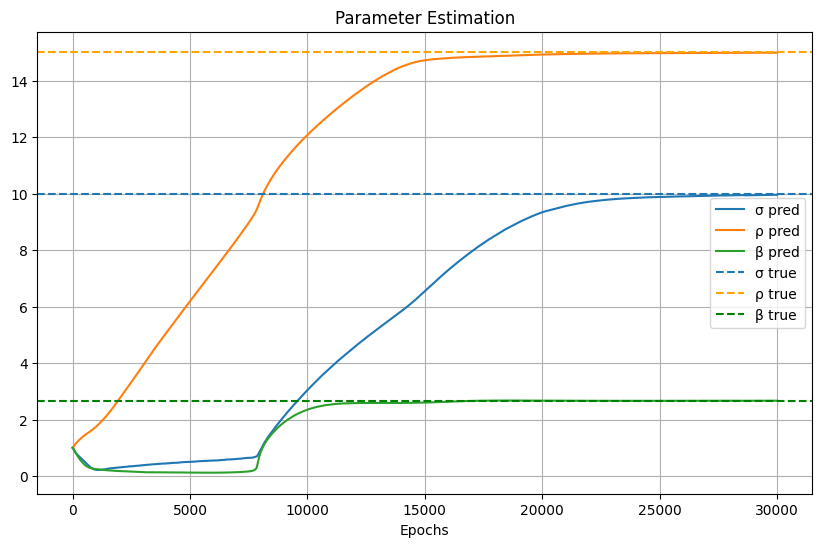

In [7]:
# 학습 파라미터 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(C1_vals, label='σ pred')
plt.plot(C2_vals, label='ρ pred')
plt.plot(C3_vals, label='β pred')
plt.axhline(10, linestyle='--', label='σ true')
plt.axhline(15, linestyle='--', color='orange', label='ρ true')
plt.axhline(8/3, linestyle='--', color='green', label='β true')
plt.title("Parameter Estimation")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.show()

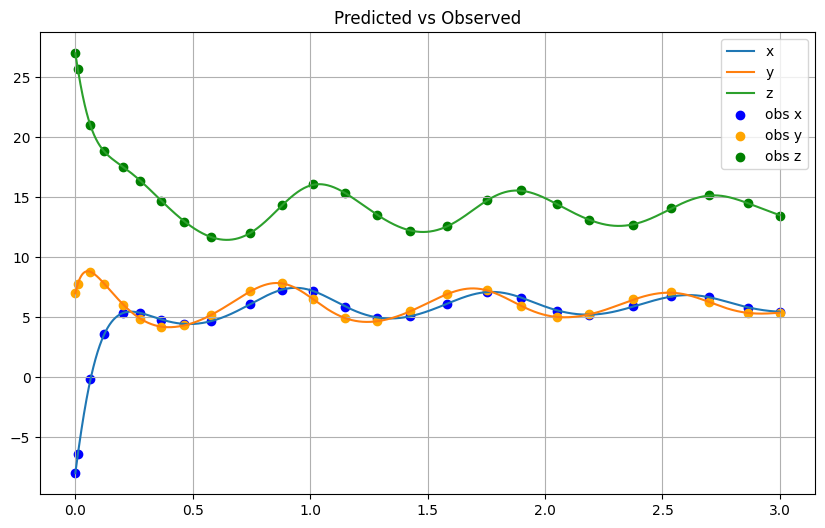

In [10]:
# 예측 결과 시각화
with torch.no_grad():
    t_eval = torch.arange(0, 3, 0.001).reshape(-1, 1).to(device)
    x, y, z = model(t_eval)

    x, y, z = x.cpu().numpy(), y.cpu().numpy(), z.cpu().numpy()
    t_eval = t_eval.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(t_eval, x, label='x')
plt.plot(t_eval, y, label='y')
plt.plot(t_eval, z, label='z')
plt.scatter(observe_t.cpu(), observe_x.cpu(), label='obs x', color='blue')
plt.scatter(observe_t.cpu(), observe_y.cpu(), label='obs y', color='orange')
plt.scatter(observe_t.cpu(), observe_z.cpu(), label='obs z', color='green')
plt.legend()
plt.title("Predicted vs Observed")
plt.grid(True)
plt.show()

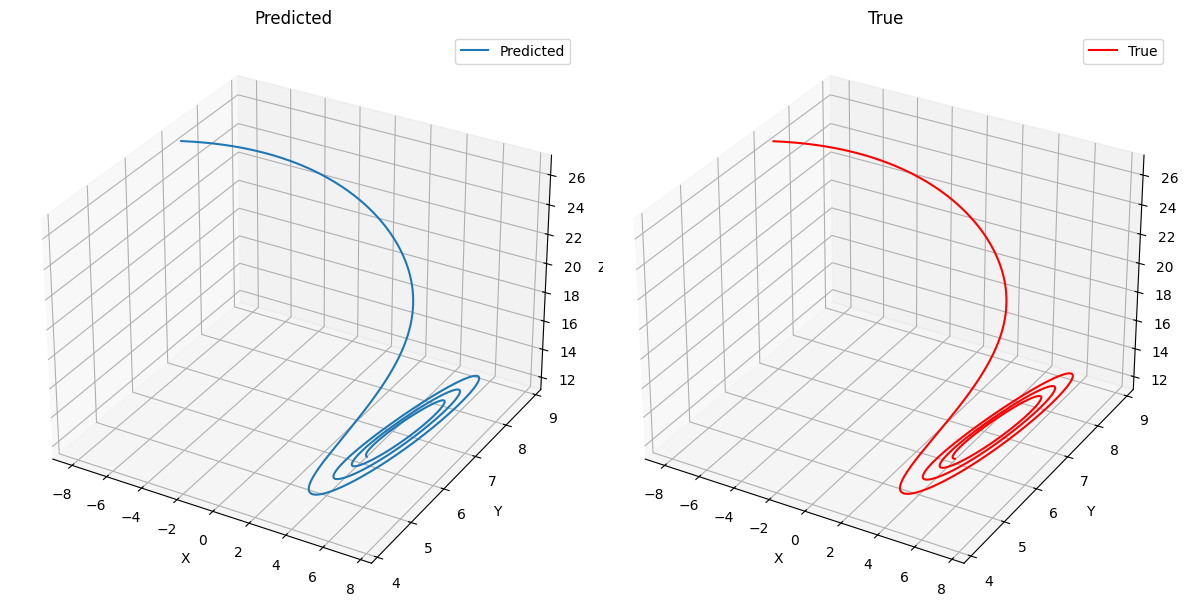

In [15]:
# Ture Solution 생성
def true_lorenz():
    def f(x, y, z, s=10, r=15, b=8/3):
        dx = s*(y - x)
        dy = r*x - y - x*z
        dz = x*y - b*z
        return dx, dy, dz

    dt = 0.001
    steps = 3000
    traj = np.empty((steps + 1, 3))
    traj[0] = (-8, 7, 27)
    for i in range(steps):
        dx, dy, dz = f(*traj[i])
        traj[i + 1] = traj[i] + dt * np.array([dx, dy, dz])
    return traj

true_traj = true_lorenz()

# 예측 vs 참값 3D 비교
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(x, y, z, label='Predicted')
ax1.set_title("Predicted")

ax2.plot(*true_traj.T, label='True', color='red')
ax2.set_title("True")

for ax in [ax1, ax2]:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

plt.tight_layout()
plt.show()


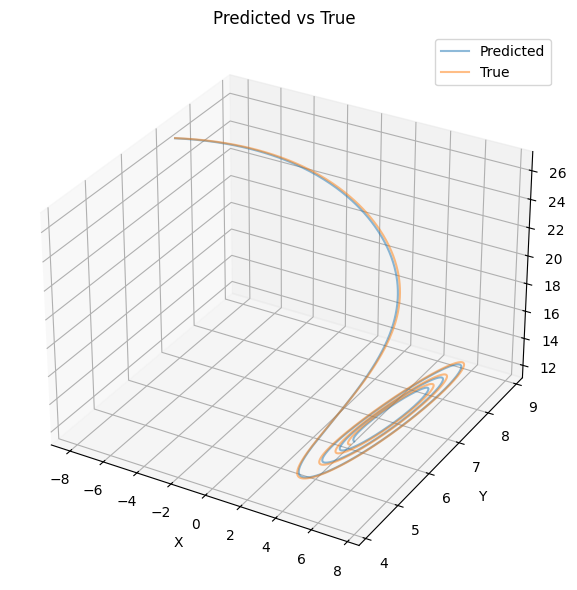

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 예측값 (x, y, z) 플롯 - 파랑, 반투명
ax.plot(x, y, z, label='Predicted', alpha=0.5)

# 참값 Lorenz 궤적 플롯 - 주황, 반투명
ax.plot(*true_traj.T, label='True', alpha=0.5)

# 라벨 및 제목
ax.set_title("Predicted vs True")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.tight_layout()
plt.show()